In [1]:
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim, cuda
from torch.utils import data as torch_data
from torchvision import datasets, transforms
from keras import layers, models, initializers

plt.rcParams['image.cmap'] = 'gray'
sns.set()
device = 'cuda' if cuda.is_available() else 'cpu'
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


### Question 1: MLP

#### The Dataset

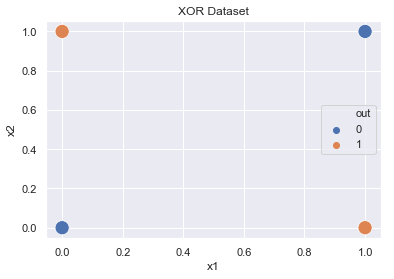

In [2]:
xor_data = pd.DataFrame({
    'x1': [0, 0, 1, 1],
    'x2': [0, 1, 0, 1],
    'out': [0, 1, 1, 0]
})

_ = sns.scatterplot(x='x1', y='x2', hue='out', data=xor_data, s=200)
_ = _.set_title("XOR Dataset")

#### Defining the network

In [3]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.1):
        init_weights = lambda shape: np.random.uniform(size=shape)
        self.w_ih = init_weights((input_dim, hidden_dim))
        self.b_h = init_weights((1, hidden_dim))
        self.w_ho = init_weights((hidden_dim, output_dim))
        self.b_o = init_weights((1, output_dim))
        self.lr = lr
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        return np.multiply(z, 1 - z)
    
    def forward(self, x):
        h = self.sigmoid(np.matmul(x, self.w_ih) + self.b_h)
        o = self.sigmoid(np.matmul(h, self.w_ho) + self.b_o)
        
        return o, h
    
    def backward(self, truth_val, out_val, hid_val):
        error = truth_val - out_val
        error_ho = np.multiply(error, self.sigmoid_prime(out_val))
        error_ih = np.matmul(error_ho, self.w_ho.T)
        error_ih = np.multiply(error_ih, self.sigmoid_prime(hid_val))
        
        return error_ih, error_ho
    
    def SGD(self, grad_ih, grad_ho, in_val, hid_val):
        self.w_ho += self.lr * np.matmul(hid_val.T, grad_ho)
        self.b_o += self.lr * np.sum(grad_ho, axis=0)#, keepdims=True)
        self.w_ih += self.lr * np.matmul(in_val.T, grad_ih)
        self.b_h += self.lr * np.sum(grad_ih, axis=0)#, keepdims=True)

    def fit(self, x, y, epochs=10):
        for _ in range(epochs):
            out, hidden = self.forward(x)
            grads = self.backward(y, out, hidden)
            self.SGD(*grads, x, hidden)
    
    def predict(self, x):
        return self.forward(x)[0]

#### Training the network

In [4]:
m = MLP(2, 2, 1)

m.fit(xor_data.values[:, :-1], np.matrix(xor_data.values[:, -1]).T, epochs=1000)
probs = m.predict(xor_data.values[:, :-1]).T.tolist()[0]
xor_data.copy().join(pd.DataFrame({
    'Prob(belonging to class 1)': probs
}))

,x1,x2,out,Prob(belonging to class 1)
0,0,0,0,0.477184
1,0,1,1,0.509593
2,1,0,1,0.506529
3,1,1,0,0.525330


#### Training Loop (Common to all questions)

In [5]:
def train_epoch(epoch_no, model, optimizer, criterion, data_l):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    for i, (features, labels) in enumerate(data_l):
        total += labels.size(0)
        
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, labels)
        _, predicted = torch.max(output, dim=-1)

        epoch_acc += (predicted == labels).sum().item()
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    return epoch_loss / total, epoch_acc / total


def train(model, optimizer, criterion, train_data, epochs=10):
    losses = []
    accs = []
    for epoch in range(epochs):
        l, a = train_epoch(epoch, model, optimizer, criterion, train_data)
        losses.append(l)
        accs.append(a)
        
        print(f"Epoch: {epoch}")
        print(f"\tLoss: {l}")
        print(f"\tAccuracy: {a}")
    
    return losses, accs

### Question 2: CNN

#### The Dataset (MNIST Handwritten Digits)

In [6]:
mnist_train = datasets.MNIST(root='.', train=True, download=True, transform=lambda x: np.array(x).reshape(1, 28, 28))
train_loader = torch_data.DataLoader(mnist_train, batch_size=1000, shuffle=True)

#### Visualizing a few examples

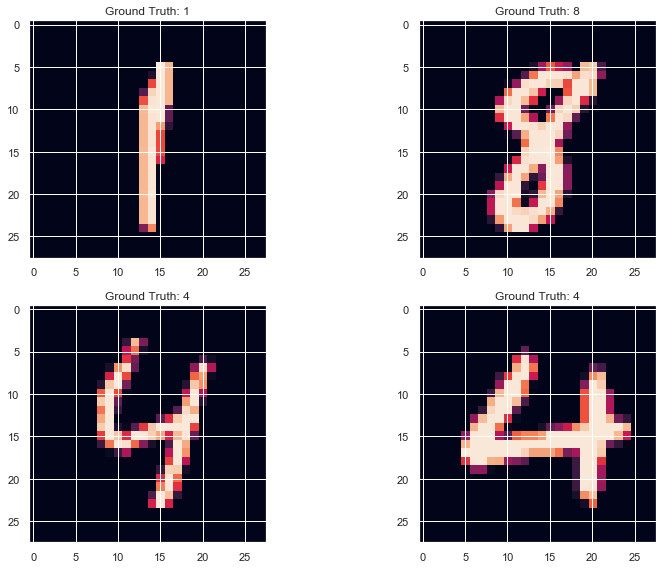

In [7]:
rand_idxs = np.random.randint(len(mnist_train), size=4)
fig, ax = plt.subplots(2, 2, figsize=(6.4 * 2, 4.8 * 2))
for i, axis in enumerate(ax.flatten()):
    example = mnist_train[rand_idxs[i]]
    _ = axis.imshow(np.squeeze(example[0]))
    _ = axis.set_title(f"Ground Truth: {example[1]}")

#### Defining the network

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, in_shape, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        channels, h, w = in_shape
        fc1_in = h - 6
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=5, kernel_size=3).to(device)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5).to(device)
        self.flatten = nn.Flatten().to(device)
        self.fc1 = nn.Linear(in_features=fc1_in * fc1_in * 10, out_features=30).to(device)
        self.fc2 = nn.Linear(in_features=30, out_features=15).to(device)
        self.out_layer = nn.Linear(in_features=15, out_features=num_classes).to(device)
        self.tanh = nn.Tanh().to(device)
        self.relu = nn.ReLU().to(device)
        self.sigmoid = nn.Sigmoid().to(device)
        self.softmax = nn.Softmax(dim=-1).to(device)
    
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x).to(device)

        x = x.float()
        x = self.tanh(self.conv1(x))
        x = self.tanh(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out_layer(x))
        return x


simple_cnn = SimpleCNN((1, 28, 28), 10)
adam_opt = optim.Adam(simple_cnn.parameters())
cel = nn.CrossEntropyLoss()

#### Training the network

Epoch: 0
	Loss: 0.0018675265689690908
	Accuracy: 0.6465666666666666
Epoch: 1
	Loss: 0.001628229123353958
	Accuracy: 0.84145
Epoch: 2
	Loss: 0.001602003171046575
	Accuracy: 0.8635333333333334
Epoch: 3
	Loss: 0.0015907064417997995
	Accuracy: 0.8732333333333333


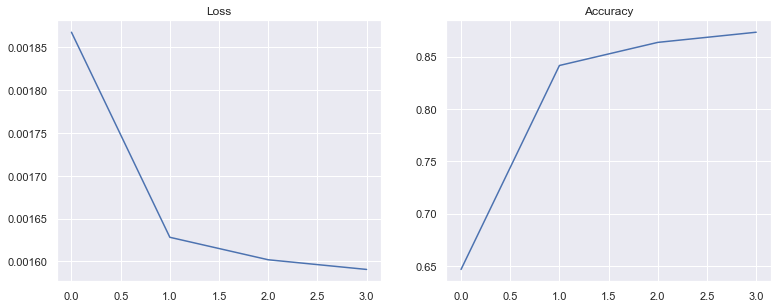

In [9]:
ls_, as_ = train(simple_cnn, adam_opt, cel, train_data=train_loader, epochs=4)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
_ = sns.lineplot(range(len(ls_)), ls_, ci=None, ax=ax[0])
_ = ax[0].set_title("Loss")
_ = sns.lineplot(range(len(as_)), as_, ci=None, ax=ax[1])
_ = ax[1].set_title("Accuracy")

#### Testing the network

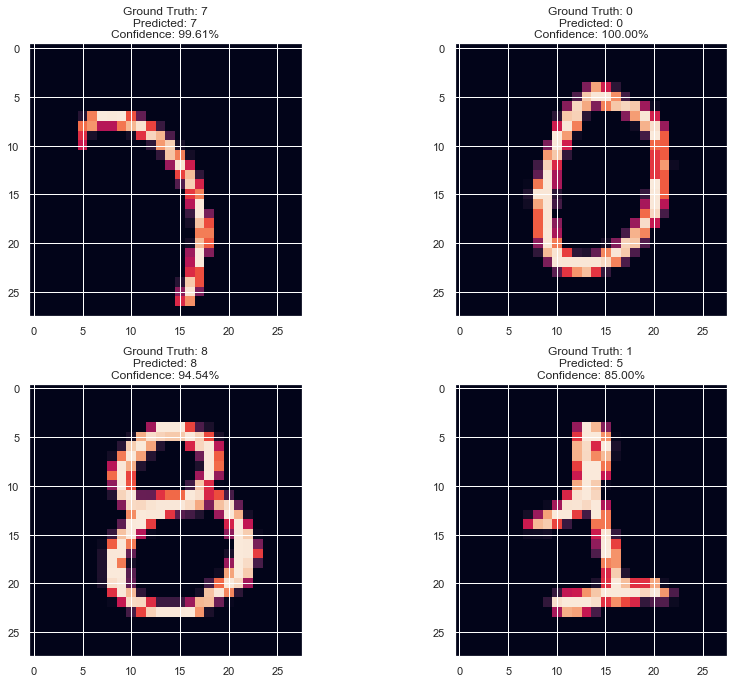

In [10]:
random_idxs = np.random.randint(len(mnist_train), size=4)
fig, ax = plt.subplots(2, 2, figsize=(6.4 * 2, 4.8 * 2))

for i, axis in enumerate(ax.flatten()):
    example = mnist_train[random_idxs[i]]
    pred = simple_cnn(np.expand_dims(example[0], axis=0))
    conf, pred = torch.max(pred, dim=-1)
    _ = axis.imshow(np.squeeze(example[0]))
    _ = axis.set_title(f"Ground Truth: {example[1]}\nPredicted: {pred.item()}\nConfidence: {conf.item() * 100:.2f}%")
plt.tight_layout()

### Question 3: LSTM Network

#### Loading the Word Embeddings
##### These embeddings are 100-dimensional embeddings taken from Stanford's GloVe embeddings

In [11]:
words = []
embed_vec_dicts = dict()
embed_matrix = []
with open("glove.6B.100d.txt", mode='r', encoding='utf-8') as f:
    for line in f:
        split_line = line.split()
        word = split_line.pop(0)
        word_vec = [eval(val) for val in split_line]
        words.append(word.lower())
        embed_vec_dicts[word] = word_vec
        embed_matrix.append(word_vec)

embed_matrix = np.matrix(embed_matrix)
print(embed_matrix.shape)
i_to_word = dict(enumerate(words))
word_to_i = {val: key for key, val in i_to_word.items()}

(400000, 100)


#### Helper Functions

In [12]:
def get_index(x):
    out = []
    for w in x:
        if w in word_to_i.keys():
            out.append(word_to_i[w])
    
    return out

#### The Dataset (IMDB Review Dataset) [and some preprocessing]

In [13]:
imdb = pd.read_csv("imdb_master.csv", header=0, encoding='cp1252', usecols=["type", "review", "label"])
imdb = imdb.loc[imdb.label != 'unsup', :]# removing the unsup class
imdb.review = imdb.review.str.lower()
imdb['inputs'] = imdb.review.str.split().apply(get_index)
imdb['is_pos_class'] = imdb.label.apply(lambda x: 1 if x == 'pos' else 0)
imdb = imdb.join(pd.get_dummies(imdb.label))
imdb.neg = imdb.neg.apply(lambda x: 1 - x)
imdb.pos = imdb.pos.apply(lambda x: 1 - x)
imdb.head()

,type,review,label,inputs,is_pos_class,neg,pos
0,test,once again mr. costner has dragged out a movie...,neg,"[442, 378, 1995, 29080, 31, 7427, 66, 7, 1005,...",0,0,1
1,test,this is an example of why the majority of acti...,neg,"[37, 14, 29, 880, 3, 738, 0, 902, 3, 608, 1588...",0,0,1
2,test,"first of all i hate those moronic rappers, who...",neg,"[58, 3, 64, 41, 5281, 155, 89385, 38, 743, 83,...",0,0,1
3,test,not even the beatles could write songs everyon...,neg,"[36, 151, 0, 9440, 94, 2432, 1499, 1402, 5, 37...",0,0,1
4,test,brass pictures (movies is not a fitting word f...,neg,"[9403, 2490, 14, 36, 7, 10634, 1388, 10, 588, ...",0,0,1


#### Splitting the dataset

In [14]:
imdb_train = imdb.loc[imdb.type == 'train', :]
imdb_test = imdb.loc[imdb.type == 'test', :]
imdb_train.index = range(imdb_train.shape[0])
imdb_test.index = range(imdb_test.shape[0])
print(f"Train: {imdb_train.shape}\nTest: {imdb_test.shape}")

Train: (25000, 7)
Test: (25000, 7)


#### The Balance of Classes

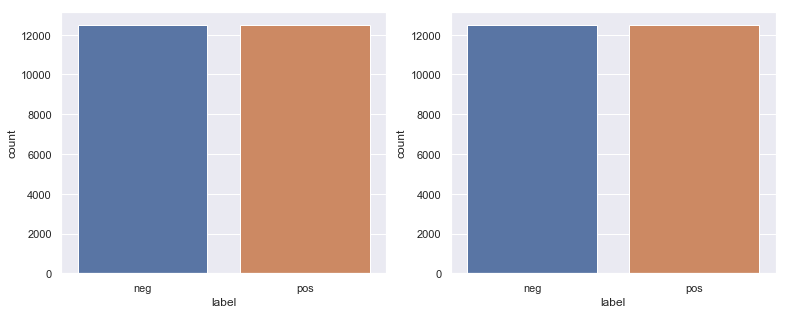

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
_ = sns.countplot(x='label', data=imdb_train, ax=ax[0])
_ = sns.countplot(x='label', data=imdb_test, ax=ax[1])

#### Making the Dataset

In [16]:
class IMDB(torch_data.Dataset):
    def __init__(self, data):
        self.data = data.reset_index().drop(['index'], axis=1)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
#         print(idx)
#         print(f"Stuff: {torch.LongTensor(self.data.loc[idx, 'inputs'])}")
#         print(f"Stuff Again: {(self.data.loc[idx, 'is_pos_class'])}") # self.data.loc[idx, slice('neg', 'pos')]
        return torch.LongTensor(self.data.loc[idx, 'inputs']), self.data.loc[idx, 'is_pos_class']


train_set = IMDB(imdb_train)
test_set = IMDB(imdb_test)

train_loader = torch_data.DataLoader(train_set, shuffle=True, batch_size=1)
test_loader = torch_data.DataLoader(test_set, shuffle=True, batch_size=1)

#### Defining the network

In [17]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim, hidden_dim, embed_mtx, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.hid = hidden_dim
        
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(embed_mtx))
        self.embedding.weight.requires_grad = False
        self.embedding.to(device)
        
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim).to(device)
        self.flatten = nn.Flatten().to(device)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2).to(device)
        self.output_layer = nn.Linear(hidden_dim // 2, num_classes).to(device)
        self.relu = nn.ReLU().to(device)
        self.tanh = nn.Tanh().to(device)
        self.softmax = nn.Softmax().to(device)
    
    def forward(self, x):
#         if type(x) != torch.Tensor:
#             x = torch.FloatTensor(x).to(device)
        x = self.embedding(x)
        out, (hidden, context) = self.lstm1(x)
        x = self.tanh(out)
#         print(f"{x.shape}")
        x = self.flatten(x)
#         print(f"X: {x.size(1)}")
        x = nn.Linear(x.size(1), self.hid // 2).to(device)(x)
        x = self.relu(x)
        x = self.softmax(self.output_layer(x))
        return x


simple_lstm = SimpleLSTM(len(pd.unique(imdb_train.label)), *embed_matrix.shape, 20, embed_matrix)
adam_opt = optim.Adam(simple_lstm.parameters())
cel = nn.CrossEntropyLoss()

#### Training the network

Epoch: 0
	Loss: 0.693332483701706
	Accuracy: 0.50384
Epoch: 1
	Loss: 0.6915407834529876
	Accuracy: 0.52376


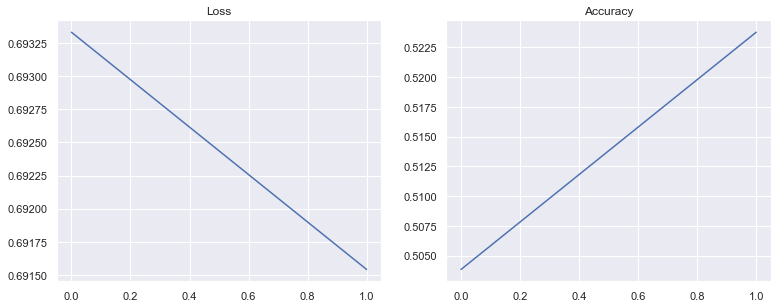

In [18]:
ls_, as_ = train(simple_lstm, adam_opt, cel, train_loader, epochs=2)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
_ = sns.lineplot(range(len(ls_)), ls_, ci=None, ax=ax[0])
_ = ax[0].set_title("Loss")
_ = sns.lineplot(range(len(as_)), as_, ci=None, ax=ax[1])
_ = ax[1].set_title("Accuracy")

In [19]:
# def get_model(num_classes, embed_mtx):
#     X_in = layers.Input(shape=(None,))
#     X = layers.Embedding(*embed_mtx.shape, input_length=None, embeddings_initializer=initializers.Constant(embed_mtx))(X_in)
#     X = layers.LSTM(50, return_sequences=True)(X)
#     X = layers.LSTM(25)(X)
#     X = layers.Dense(num_classes, activation='softmax')(X)
    
#     return models.Model(inputs=X_in, outputs=X)

In [20]:
# lstm_model = get_model(len(pd.unique(imdb_train.label)), embed_matrix)
# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy')
# lstm_model.fit(imdb_train.inputs, imdb_train.loc[:, slice('neg', 'pos')], batch_size=1)